# Prep.

In [1]:
require(tidyverse)
require(deSolve)
require(DiagrammeR)
require(patchwork)
require(scales)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: deSolve

Loading required package: DiagrammeR

Loading required package: patchwork

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## Utils

In [2]:
figsize = \(width=8,height=6)
    options(repr.plot.width=width, repr.plot.height=height)

In [3]:
timeit = \(exp) {
    t = Sys.time()
    r = eval.parent(bquote(.(exp)))
    show(Sys.time() - t)
    r
}

In [4]:
spec = quote(\(t,u,p) {
    N = u[S]+u[I]+u[R]
    move(S, I, p$beta*I*S)
    move(I, R, p$gamma*I)
})

In [5]:
make.model = \(spec) {
    state = list()
    body = list()
    push.state = \(k,v) state[[k]][[length(state[[k]])+1]] <<- v
    push.body = \(v) body[[length(body)+1]] <<- v
    
    env = list(
        move = \(from,to,count, ...) {            
            push.state(substitute(from), bquote(- .(substitute(count))))
            push.state(substitute(to), substitute(count))
        },
        '<-' = \(lhs, rhs) {
            push.body(bquote(.(substitute(lhs)) <- .(substitute(rhs))))
        },
        add = \(to, count, ...) {
            push.state(substitute(to), substitute(count))
        }
    )
    env['='] = env['<-']
    
    do.call(with, list(env, spec[[3]]))
    
    for(k in names(state)) {
        rhs = Reduce(\(acc,x) bquote(.(acc) + .(x)), state[[k]])
        push.body(bquote(du[.(as.symbol(k))] <- .(rhs)))
    }

    eval.parent(call('function', spec[[2]], bquote(splice=TRUE, {
        du = c()
        ..(body)
        list(du[names(u)])
    })))
}
make.model(spec)

function (t, u, p) 
{
    du = c()
    N <- u[S] + u[I] + u[R]
    du[S] <- -(p$beta * I * S)
    du[I] <- p$beta * I * S + -(p$gamma * I)
    du[R] <- p$gamma * I
    list(du[names(u)])
}

In [6]:
make.graph = \(spec) {
    desub = \(x) eval.parent(bquote(deparse(substitute(.(substitute(x))))))
    label = list()
    edge = list()
    push.label = \(x) label[length(label)+1] <<- x
    push.edge = \(x) edge[length(edge)+1] <<- x
    env = list(
        move = \(from,to,count, ...) {
            push.edge(sprintf('%s -> %s [label=<%s>]', 
                              desub(from), desub(to), desub(count)))
        },
        '<-' = \(lhs, rhs, ...) {
            push.label(sprintf('%s = %s', desub(lhs), desub(rhs)))
        },
        add = \(to, count, loop=FALSE) {
            if(loop) 
                push.edge(sprintf('%s -> %s [label=<%s>]', desub(to), desub(to), desub(count)))
            else 
                push.edge(sprintf('_ -> %s [label=<%s>]', desub(to), desub(count)))
        }
    )
    env['='] = env['<-']
    do.call(with, list(env, spec[[3]]))
    
    grViz(width=400, height=400, sprintf(
        'digraph {
            _ [label="", shape=none]
            label = <%s>
            %s
        }',
        do.call(paste, c(label, sep='<br/>')),
        do.call(paste, c(edge, sep='\n'))
    ))    
}
make.graph(spec)

HTML widgets cannot be represented in plain text (need html)

In [7]:
# tensor product
`%x%` = \(x,y) {
    z = matrix(nrow=nrow(x)*nrow(y), ncol=ncol(x)*ncol(y))
    for(i in 1:nrow(x)) {
        for(j in 1:ncol(x)) {
            z[(1+(i-1)*nrow(y)):(i*nrow(y)), (1+(j-1)*ncol(y)):(j*ncol(y))] = x[i,j] * y
        }
    }
    z
}
A = matrix(c(1,2), ncol=1)
B = matrix(c(1,2,3,4), ncol=2)
show(A)
show(B)
show(A %x% B)

     [,1]
[1,]    1
[2,]    2
     [,1] [,2]
[1,]    1    3
[2,]    2    4
     [,1] [,2]
[1,]    1    3
[2,]    2    4
[3,]    2    6
[4,]    4    8


In [134]:
# function composition (f %o% g)(x) = f(g(x))
`%o%` = \(f,g) \(x) f(g(x))

In [137]:
((\(x) 1+x) %o% abs)(-1)

[1] 2

## Data

In [8]:
# age categories
ages = seq(0, by=5, length.out = 16)

### Population by age and sex

In [9]:
# https://www.mhlw.go.jp/english/database/db-hh/1-1.html
population = readxl::read_xlsx('japan-total-population.xlsx') %>%
    drop_na %>%
    .[2:19, 2:4] %>%
    set_names('total', 'male', 'female') %>%
    {
        .[1:16, 'age'] = ages
        fill(., age)
    } %>%
    mutate(across(-age, ~ as.numeric(.)*1e3)) %>%
    group_by(age) %>%
    summarise(
        age = first(age),
        across(c(total,male,female), ~ sum(.)),        
    )
population

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


age total    male    female  
1   0   4541360 2324576  2216784
2   5   5114175 2619882  2494293
3  10   5376067 2755578  2620489
4  15   5706306 2927618  2778688
5  20   6319959 3233994  3085965
6  25   6384151 3279149  3105002
7  30   6713773 3431250  3282523
8  35   7498375 3805952  3692423
9  40   8476244 4298675  4177569
10 45   9868454 4993896  4874558
11 50   8738079 4394401  4343678
12 55   7940132 3966900  3973232
13 60   7442392 3676742  3765650
14 65   8236274 3999342  4236932
15 70   9188550 4336923  4851627
16 75  18601808 7304703 11297105

### Fertility rate by age of mother

In [10]:
# https://www.mhlw.go.jp/stf/wp/hakusyo/kousei/19/backdata/01-01-01-11.html
fertility.rate = readxl::read_xls('japan-birth-rate-by-age-of-mother.xls') %>%
    set_names(c('year', seq(15,by=5,to = 49))) %>%
    .[3:72,] %>%
    mutate(across(everything(), ~ as.numeric(.)))
tail(fertility.rate)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`


year 15     20     25     30     35     40     45    
1 2014 0.0224 0.1487 0.4204 0.5034 0.2747 0.0516 0.0014
2 2015 0.0206 0.1475 0.4215 0.5173 0.2864 0.0557 0.0015
3 2016 0.0190 0.1433 0.4139 0.5147 0.2907 0.0586 0.0015
4 2017 0.0170 0.1379 0.4077 0.5128 0.2910 0.0596 0.0016
5 2018 0.0153 0.1329 0.4038 0.5118 0.2895 0.0609 0.0017
6 2019 0.0137 0.1243 0.3858 0.4940 0.2805 0.0609 0.0017

### Death rate by age and sex

In [11]:
# https://www.mhlw.go.jp/english/database/db-hw/lifetb21/index.html
.death.rate = cbind(
    readxl::read_xlsx('japan-life-table.xlsx', sheet='life　table(male）') %>% .[,c(1,3)],
    readxl::read_xlsx('japan-life-table.xlsx', sheet='life　table（female）') %>%  .[,3]
) %>%
    tail(-14) %>%
    set_names('age', 'male', 'female') %>%
    mutate_all(as.numeric) %>%
    drop_na

head(.death.rate)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `age = .Primitive("as.double")(age)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


age male    female 
1 0   0.00182 0.00160
2 1   0.00023 0.00022
3 2   0.00016 0.00015
4 3   0.00011 0.00010
5 4   0.00009 0.00007
6 5   0.00008 0.00006

The life expectancy $E[x-a \mid a]$ at age $a$ can be calculated as
$$
\begin{align}
E[x-a \mid a] 
& = \sum_{x=0}^\infty (x-a) P\{\text{death at age $x$} \mid \text{survive at age $a$}\} \\
& = \sum_{x=a+1}^\infty x \frac{P\{\text{death at age $x$}\}}{P\{\text{survive at age $a$}\}} - a\\
& = \sum_{x=a+1}^\infty x \frac{l(x)-l(x+1)}{l(a)} - a\\
& = \frac{\sum_{x=a}^\infty l(x)}{l(a)}
\end{align}
$$
where
survivorship $\displaystyle l(a) = \prod_{x=0}^{a-1} (1-h(x))$ and
death rate $h(a)$.

In [12]:
life.expectancy = .death.rate %>%
    mutate(across(c(male, female), ~ {
        h = .
        l = cumprod(replace_na(1-lag(h),1))
        rev(cumsum(rev(l)))/l
    }))
head(life.expectancy)

age male     female  
1 0   81.97633 88.06278
2 1   81.12398 87.20231
3 2   80.14241 86.22128
4 3   79.15507 85.23406
5 4   78.16367 84.24248
6 5   77.17062 83.24831

In [13]:
death.rate = .death.rate %>%
    left_join(data.frame(age.group=ages), by=join_by(age==age.group), keep = TRUE) %>%
    fill(age.group) %>%
    group_by(age.group) %>%
    summarise(across(c(male, female), ~ 1-prod(1-.)))
death.rate

age.group male         female      
1   0        0.0024088017 0.0021390333
2   5        0.0003599483 0.0002699709
3  10        0.0004399241 0.0003799434
4  15        0.0013293057 0.0008397196
5  20        0.0023677567 0.0012793451
6  25        0.0025074816 0.0013492717
7  30        0.0028766901 0.0016788737
8  35        0.0037942387 0.0021781047
9  40        0.0053784291 0.0033953971
10 45        0.0088784755 0.0052589579
11 50        0.0149798992 0.0084414429
12 55        0.0237814102 0.0117346269
13 60        0.0376426827 0.0166187708
14 65        0.0607647929 0.0255069207
15 70        0.0986201360 0.0417487826
16 75        1.0000000000 1.0000000000

### Contact matrix by age

In [14]:
contact.matrix = list()
for(name in c('home', 'school', 'work', 'other_locations')) {
    contact.matrix[[name]] = readxl::read_xlsx(
        sheet = 'Japan',
        str_interp('contact_matrices_152_countries/MUestimates_${name}_1.xlsx')
    ) %>%
        set_names(ages)
}

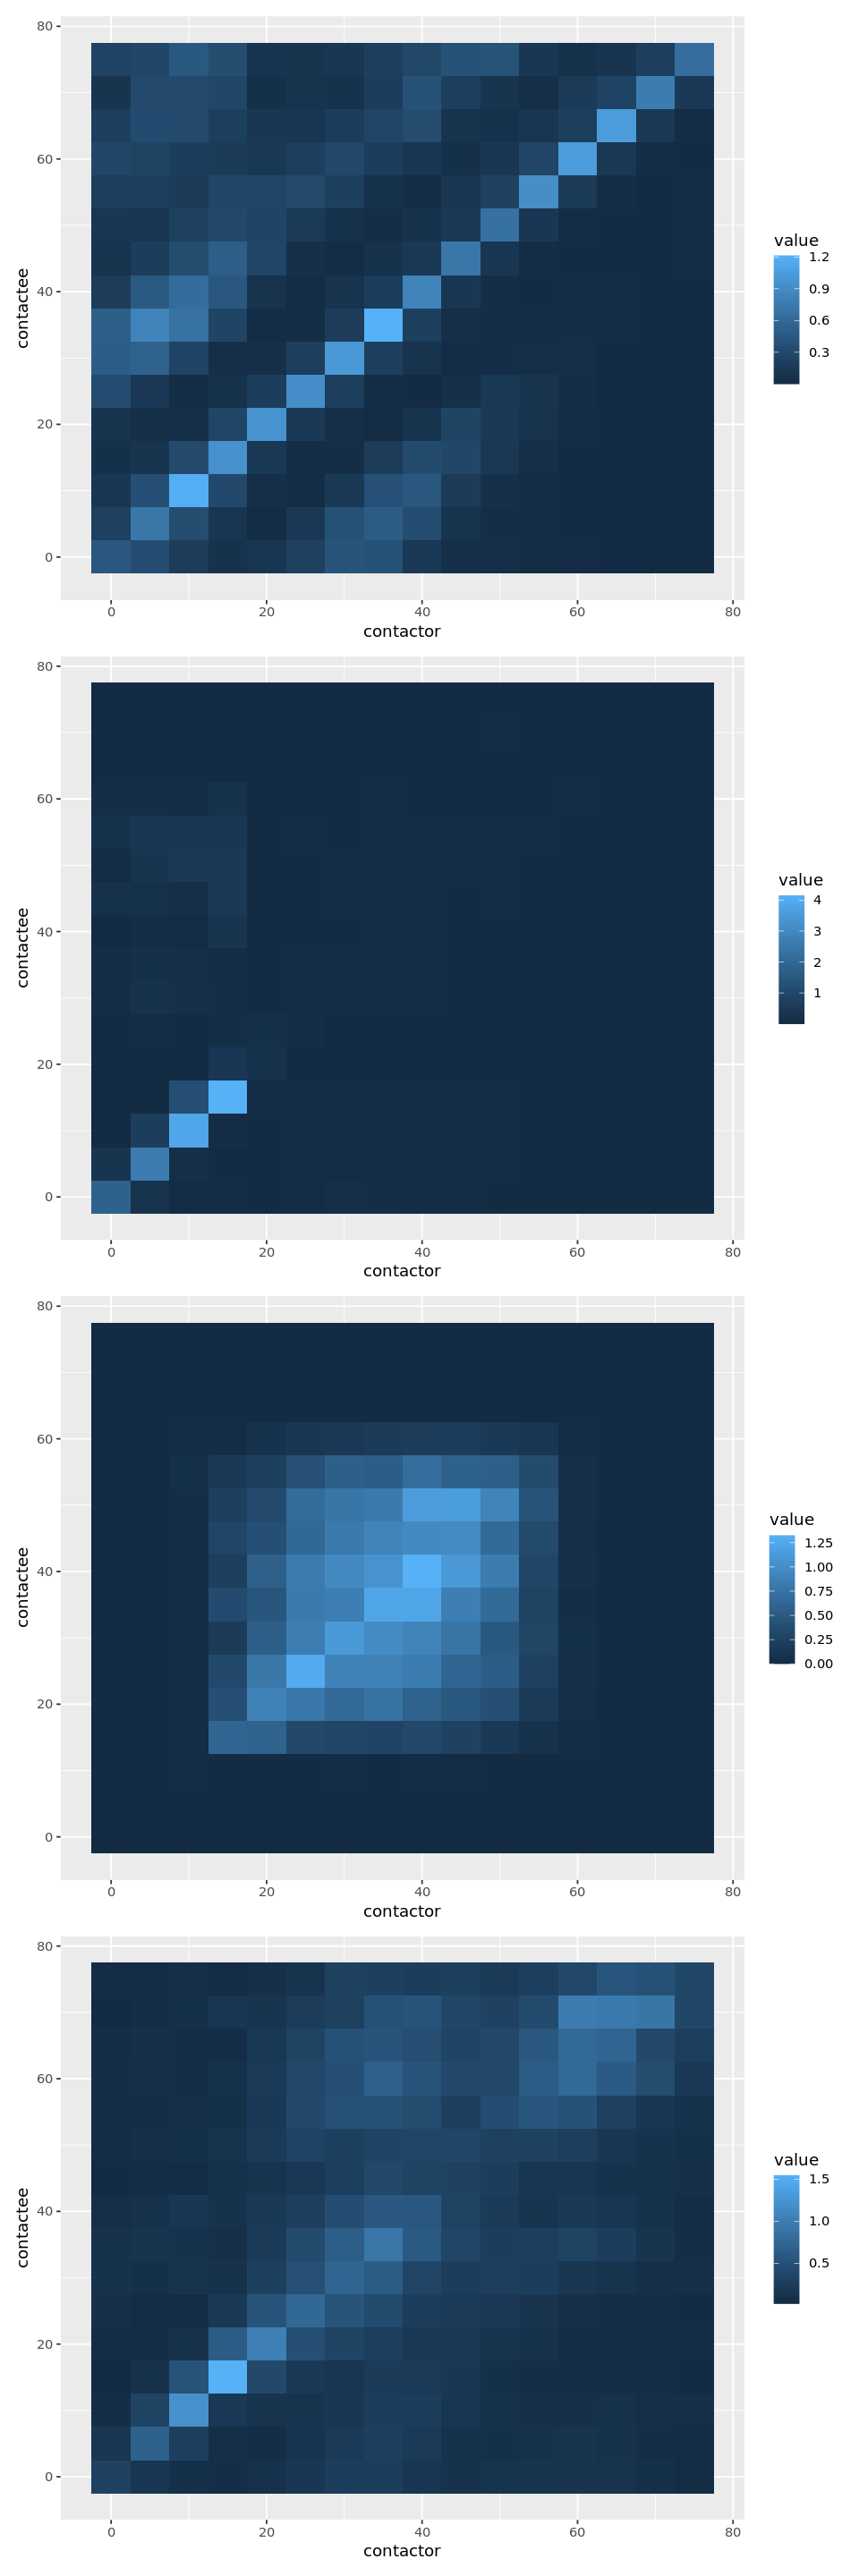

In [15]:
figsize(height=24)
g.acc = NULL
for(name in names(contact.matrix)) {
    g = contact.matrix[[name]] %>%
        mutate(contactee = ages) %>%
        pivot_longer(as.character(ages), names_to = 'contactor') %>%
        mutate(contactor = as.numeric(contactor)) %>%
        ggplot() +
        geom_bin2d(aes(contactor, contactee, fill=value), stat='identity')
        labs(fill = name)
    if(is.null(g.acc)) g.acc = g
    else g.acc = g.acc / g
}
g.acc

### Seasonal forcing by month

Rows: 12 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): month, Re

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


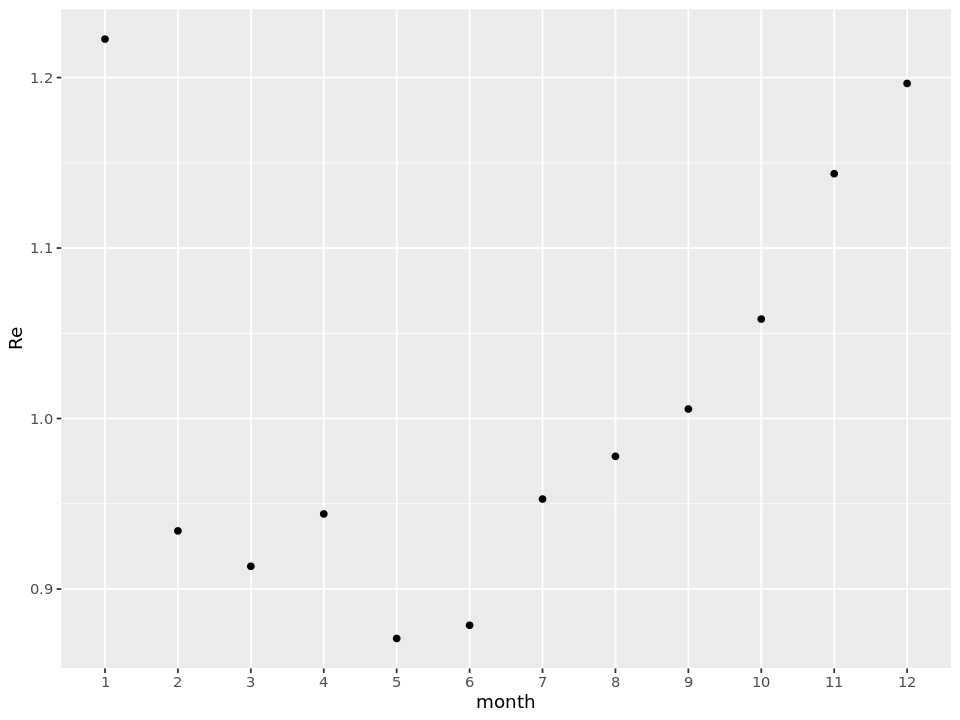

In [16]:
# 'R-seasonal-forcing-japan.ipynb'
seasonal.forcing = read_csv('flu-Re-monthly.csv') %>%
    mutate(month = factor(month))

figsize()
ggplot(seasonal.forcing) +
    geom_point(aes(month, Re)) 

### Infection Fatality Rate by age

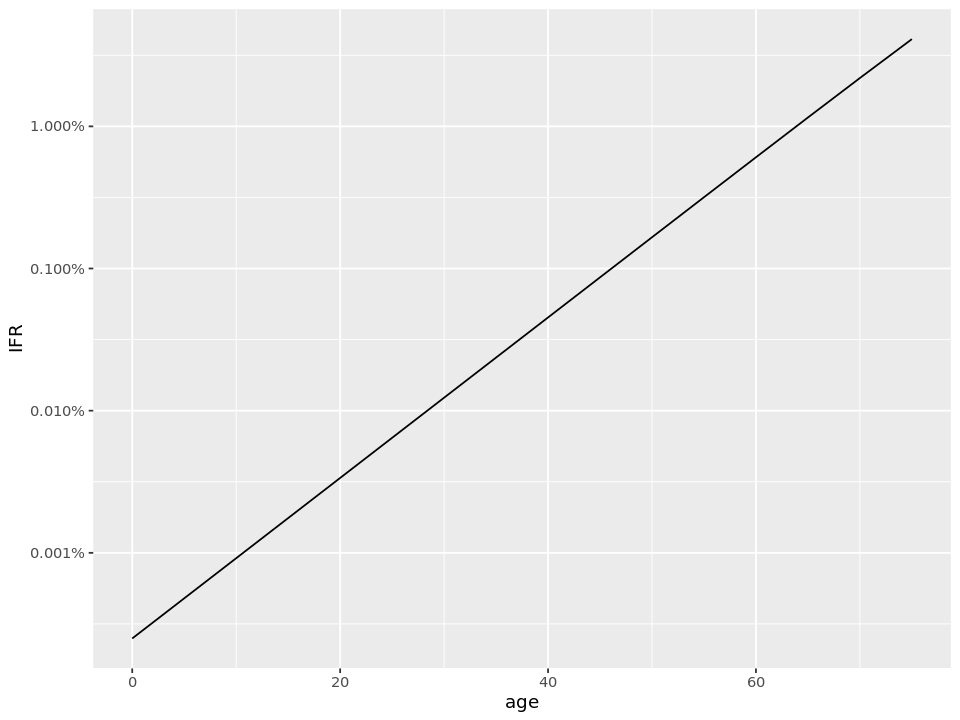

In [17]:
# https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-022-07262-0#Sec19
ifr = data.frame(age = ages) %>%
    mutate(
        IFR = {
            odds = exp(-12.9 + .13*age)
            odds/(odds+1)
        }
    )
figsize()
ggplot(ifr) +
    geom_line(aes(age, IFR)) +
    scale_y_log10(labels = percent)

# age-structured SIR model with partial immunity

## Model

In [18]:
state = crossing(
    symbol = fct(c('S', 'I', 'R', 'A', 'Dd', 'Dn')),
    sex = fct(c('male', 'female')),
    age = ages
) %>%
    mutate(label = paste(symbol, sex, age, sep='.'))
head(state)

symbol sex  age label    
1 S      male  0  S.male.0 
2 S      male  5  S.male.5 
3 S      male 10  S.male.10
4 S      male 15  S.male.15
5 S      male 20  S.male.20
6 S      male 25  S.male.25

In [19]:
S = state %>% filter(symbol=='S') %>% pull(label)
I = state %>% filter(symbol=='I') %>% pull(label)
R = state %>% filter(symbol=='R') %>% pull(label)
A = state %>% filter(symbol=='A') %>% pull(label)
Dd = state %>% filter(symbol=='Dd') %>% pull(label)
Dn = state %>% filter(symbol=='Dn') %>% pull(label)
S

[1] "S.male.0"    "S.male.5"    "S.male.10"   "S.male.15"   "S.male.20"  
 [6] "S.male.25"   "S.male.30"   "S.male.35"   "S.male.40"   "S.male.45"  
[11] "S.male.50"   "S.male.55"   "S.male.60"   "S.male.65"   "S.male.70"  
[16] "S.male.75"   "S.female.0"  "S.female.5"  "S.female.10" "S.female.15"
[21] "S.female.20" "S.female.25" "S.female.30" "S.female.35" "S.female.40"
[26] "S.female.45" "S.female.50" "S.female.55" "S.female.60" "S.female.65"
[31] "S.female.70" "S.female.75"

In [20]:
spec = quote(\(t,u,p) {
    N = u[S] + u[I] + u[R] + u[A]
    J = (u[I] + p$eta * u[A])/N
    bJ = p$seasonal(t) * (p$beta %*% J)
    
    # SIRS
    move(S,I, bJ*u[S])
    move(I,R, p$gamma*u[I])
    move(R,S, p$mu*u[R])
    
    # partial immunity
    move(R,A, bJ*u[R])
    move(A,R, p$gamma*u[A])
    
    # death from infection
    move(I, Dd, p$delta*u[I])
    move(A, Dd, p$delta*p$kappa*u[A])
    
    # birth and death
    add(S, p$birth(N))
    move(S, Dn, p$death(u[S]))
    move(I, Dn, p$death(u[I]))
    move(R, Dn, p$death(u[R]))
    move(A, Dn, p$death(u[A]))
    
    # aging
    add(S, p$aging(u[S]), loop=TRUE)
    add(I, p$aging(u[I]), loop=TRUE)
    add(R, p$aging(u[R]), loop=TRUE)
    add(A, p$aging(u[A]), loop=TRUE)
})

make.graph(spec)

HTML widgets cannot be represented in plain text (need html)

## Params

### Const.

In [59]:
R0 = 2.5/seasonal.forcing[[1,'Re']]
generation.interval = 5
immunity.duration = 100
relative.infectivity = 1/2
relative.fatality = 1/20

In [60]:
params = list(
    gamma = 1/generation.interval,
    mu = 1/immunity.duration,
    eta = relative.infectivity,
    kappa = relative.fatality
)

### IFR by age

In [61]:
params[['delta']] = ifr$IFR

### Death from other sources

In [302]:
aging.speed = 1/(365*5)
death.speed = death.rate %>% 
    mutate(across(c(male, female), ~ ./(1-.) * aging.speed)) %>%
    head(-1) %>%
    rbind(
        life.expectancy %>%
            filter(age == 75) %>%
            transmute(
                age.group = age,
                across(c(male, female), ~ 1/(.*365))
            )
    )

params[['death']] = \(u) {
    du = c()
    du[names(u)] = u * with(death.speed, c(male, female))
    du[names(u)]
}

### Aging

In [116]:
params[['aging']] = \(u) {
    du = c()
    du[names(u)] = 0
    du[names(u)[1]] = - u[1] * aging.speed
    du[names(u)[2:15]] = u[1:14] * aging.speed - u[2:15] * aging.speed
    du[names(u)[1+16]] = - u[1+16] * aging.speed
    du[names(u)[(2:15)+16]] = u[(1:14)+16] * aging.speed - u[(2:15)+16] * aging.speed
    du[names(u)]
}

### Birth
The fertility rate $r(g)$ at age group $g$ is simply the sum of the rate $r(a)$ at each age $a$ in the group. To use this rate as annual constant hazard(birth) rate, we have to divide it by the width of its age group.

In [117]:
daily.fertility.rate = left_join(
    state %>% filter(symbol == 'S') %>% select(sex,age),
    fertility.rate %>%
        filter(year == max(year)) %>%
        pivot_longer(-year, names_to = 'age', values_to = 'rate') %>%
        mutate(
            age = as.numeric(age),
            sex = 'female'
        ) %>%
        select(sex, age, rate)
) %>%
    replace(is.na(.), 0) %>%
    mutate(rate = 1-(1-rate/5)^(1/365)) %>% # annually to daily
    pull(rate)

params[['birth']] = \(N) {
    du = c()
    du[names(N)] = 0
    total.birth = sum(daily.fertility.rate * N)
    du[[1]] = total.birth/2
    du[[17]] = total.birth/2
    du[names(N)]
}

Joining with `by = join_by(sex, age)`


### Contact pattern

In [118]:
params[['beta']] = with(c(), {
    p.under20 = population %>% mutate(p = total / sum(total)) %>% filter(age %in% c(0,5,10,15)) %>% pull(p) %>% sum
    p.over20 = population %>% mutate(p = total / sum(total)) %>% filter(!(age %in% c(0,5,10,15))) %>% pull(p) %>% sum

    C = matrix(c(1,1,1,1), ncol=2) %x%
        with(contact.matrix, as.matrix(
            home*8 + (school*p.under20 + work*p.over20)*8 + other_locations*8
        )/24)
    beta = abs(R0/generation.interval/eigen(C)$values[[1]])
    beta*C
})

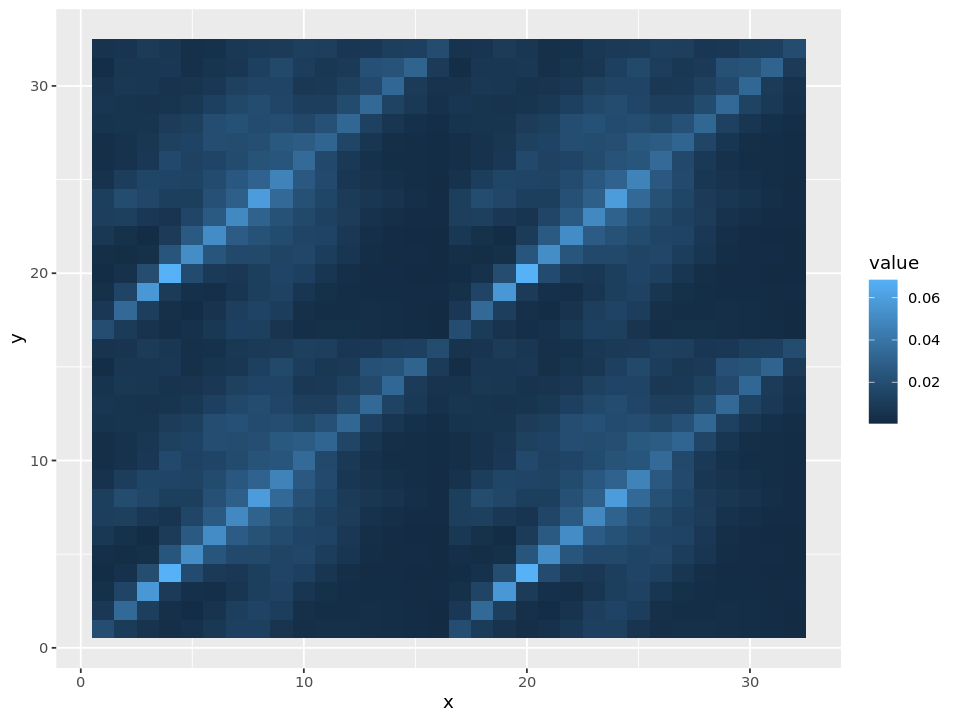

In [119]:
figsize()
data.frame(params[['beta']]) %>%
    set_names(1:32) %>%
    mutate(y = 1:32) %>%
    pivot_longer(1:32, names_to = 'x') %>%
    mutate(across(c(x,y), ~ as.numeric(.))) %>%
    ggplot() +
    geom_bin2d(aes(x,y,fill=value), stat='identity')

### Seasonal forcing

In [120]:
yday2Re = rep(seasonal.forcing$Re, c(31,28,31,30,31,30, 31,31,30,31,30,31))

params[['seasonal']] = \(t) {    
    yday = (t %% 365) + 1
    yday2Re[[yday]]
}

## Validation

### Daily birth and death
[According to Japanese Health department(MHLW)](https://www.mhlw.go.jp/wp/hakusyo/kousei/21-3/), the number of daily birth and death are 2,224 and 3,945 respectively. 

In [121]:
p = c()
p[S] = with(population, c(male, female))
sum(params$birth(p))

[1] 2580.969

In [122]:
sum(params$death(p))

[1] 4349.221

### Simulate with no infective

In [308]:
u0 = c()
u0[S] = with(population, c(male, female))
u0[c(I,R,A,Dn,Dd)] = 0
timeit({
    sol = ode(
        u0,
        seq(0,365*40,by=1),
        make.model(spec),
        params
    ) %>% data.frame
    head(sol)
})

Time difference of 9.942844 secs


time S.male.0 S.male.5 S.male.10 S.male.15 S.male.20 S.male.25 S.male.30
1 0    2324576  2619882  2755578   2927618   3233994   3279149   3431250  
2 1    2324590  2619720  2755503   2927522   3233822   3279120   3431161  
3 2    2324603  2619558  2755428   2927425   3233650   3279090   3431073  
4 3    2324617  2619395  2755353   2927329   3233478   3279061   3430984  
5 4    2324630  2619233  2755278   2927232   3233306   3279031   3430895  
6 5    2324644  2619072  2755202   2927136   3233134   3279002   3430807  
  S.male.35 S.male.40 ⋯ Dd.female.30 Dd.female.35 Dd.female.40 Dd.female.45
1 3805952   4298675   ⋯ 0            0            0            0           
2 3805739   4298392   ⋯ 0            0            0            0           
3 3805526   4298110   ⋯ 0            0            0            0           
4 3805313   4297827   ⋯ 0            0            0            0           
5 3805100   4297544   ⋯ 0            0            0            0           
6 3804887   4297262   ⋯ 0            0            0            0           
  Dd.female.50 Dd.female.55 Dd.female.60 Dd.female.65 Dd.female.70 Dd.female.75
1 0            0            0            0            0            0           
2 0            0            0            0            0            0           
3 0            0            0            0            0            0           
4 0            0            0            0            0            0           
5 0            0            0            0            0            0           
6 0            0            0            0            0            0

In [324]:
rowSums(sol[s[[1,'label']][[1]]])

[1] 2324576 2324590 2324603 2324617 2324630 2324644 2324657 2324670 2324684
   [10] 2324697 2324710 2324723 2324736 2324749 2324762 2324775 2324788 2324801
   [19] 2324814 2324826 2324839 2324852 2324864 2324877 2324889 2324901 2324914
   [28] 2324926 2324938 2324951 2324963 2324975 2324987 2324999 2325011 2325023
   [37] 2325034 2325046 2325058 2325070 2325081 2325093 2325104 2325116 2325127
   [46] 2325139 2325150 2325161 2325172 2325184 2325195 2325206 2325217 2325228
   [55] 2325239 2325250 2325260 2325271 2325282 2325293 2325303 2325314 2325324
   [64] 2325335 2325345 2325356 2325366 2325376 2325386 2325396 2325407 2325417
   [73] 2325427 2325437 2325447 2325456 2325466 2325476 2325486 2325495 2325505
   [82] 2325515 2325524 2325534 2325543 2325552 2325562 2325571 2325580 2325589
   [91] 2325598 2325607 2325617 2325625 2325634 2325643 2325652 2325661 2325670
  [100] 2325678 2325687 2325695 2325704 2325712 2325721 2325729 2325738 2325746
  [109] 2325754 2325762 2325770 2325779 2325787 2325795 2325803 2325810 2325818
  [118] 2325826 2325834 2325842 2325849 2325857 2325864 2325872 2325879 2325887
  [127] 2325894 2325901 2325909 2325916 2325923 2325930 2325937 2325944 2325951
  [136] 2325958 2325965 2325972 2325979 2325985 2325992 2325999 2326005 2326012
  [145] 2326018 2326025 2326031 2326038 2326044 2326050 2326056 2326063 2326069
  [154] 2326075 2326081 2326087 2326093 2326099 2326104 2326110 2326116 2326122
  [163] 2326127 2326133 2326138 2326144 2326149 2326155 2326160 2326166 2326171
  [172] 2326176 2326181 2326186 2326191 2326196 2326201 2326206 2326211 2326216
  [181] 2326221 2326226 2326230 2326235 2326240 2326244 2326249 2326253 2326258
  [190] 2326262 2326266 2326271 2326275 2326279 2326283 2326287 2326291 2326295
  [199] 2326299 2326303 2326307 2326311 2326315 2326319 2326322 2326326 2326330
  [208] 2326333 2326337 2326340 2326344 2326347 2326350 2326353 2326357 2326360
  [217] 2326363 2326366 2326369 2326372 2326375 2326378 2326381 2326384 2326387
  [226] 2326389 2326392 2326395 2326397 2326400 2326402 2326405 2326407 2326410
  [235] 2326412 2326414 2326416 2326419 2326421 2326423 2326425 2326427 2326429
  [244] 2326431 2326433 2326435 2326436 2326438 2326440 2326441 2326443 2326445
  [253] 2326446 2326448 2326449 2326451 2326452 2326453 2326454 2326456 2326457
  [262] 2326458 2326459 2326460 2326461 2326462 2326463 2326464 2326465 2326465
  [271] 2326466 2326467 2326467 2326468 2326469 2326469 2326470 2326470 2326470
  [280] 2326471 2326471 2326471 2326471 2326472 2326472 2326472 2326472 2326472
  [289] 2326472 2326472 2326471 2326471 2326471 2326471 2326470 2326470 2326470
  [298] 2326469 2326469 2326468 2326468 2326467 2326466 2326466 2326465 2326464
  [307] 2326463 2326462 2326461 2326460 2326459 2326458 2326457 2326456 2326455
  [316] 2326454 2326453 2326451 2326450 2326448 2326447 2326446 2326444 2326442
  [325] 2326441 2326439 2326438 2326436 2326434 2326432 2326430 2326428 2326426
  [334] 2326424 2326422 2326420 2326418 2326416 2326414 2326412 2326409 2326407
  [343] 2326405 2326402 2326400 2326397 2326395 2326392 2326390 2326387 2326384
  [352] 2326382 2326379 2326376 2326373 2326370 2326367 2326364 2326361 2326358
  [361] 2326355 2326352 2326349 2326345 2326342 2326339 2326335 2326332 2326329
  [370] 2326325 2326322 2326318 2326314 2326311 2326307 2326303 2326299 2326296
  [379] 2326292 2326288 2326284 2326280 2326276 2326272 2326268 2326264 2326259
  [388] 2326255 2326251 2326247 2326242 2326238 2326233 2326229 2326224 2326220
  [397] 2326215 2326211 2326206 2326201 2326197 2326192 2326187 2326182 2326177
  [406] 2326172 2326167 2326162 2326157 2326152 2326147 2326142 2326136 2326131
  [415] 2326126 2326120 2326115 2326109 2326104 2326098 2326093 2326087 2326082
  [424] 2326076 2326070 2326065 2326059 2326053 2326047 2326041 2326035 2326029
  [433] 2326023 2326017 2326011 2326005 2325999 2325992 2325986 2325980 2325973
  [442] 2325967 2325960 2325954 2325948 2325941 2325934 2325928 2325921 2325914
  [4

In [325]:
df = state %>%
    filter(symbol %in% c('S', 'I', 'R', 'A')) %>%
    group_by(sex,age) %>%
    reframe(data.frame(
        time = sol$time,
        n = rowSums(sol[label])
    ))
head(df)

sex  age time n      
1 male 0   0    2324576
2 male 0   1    2324590
3 male 0   2    2324603
4 male 0   3    2324617
5 male 0   4    2324630
6 male 0   5    2324644

`summarise()` has grouped output by 'time', 'sex'. You can override using the
`.groups` argument.


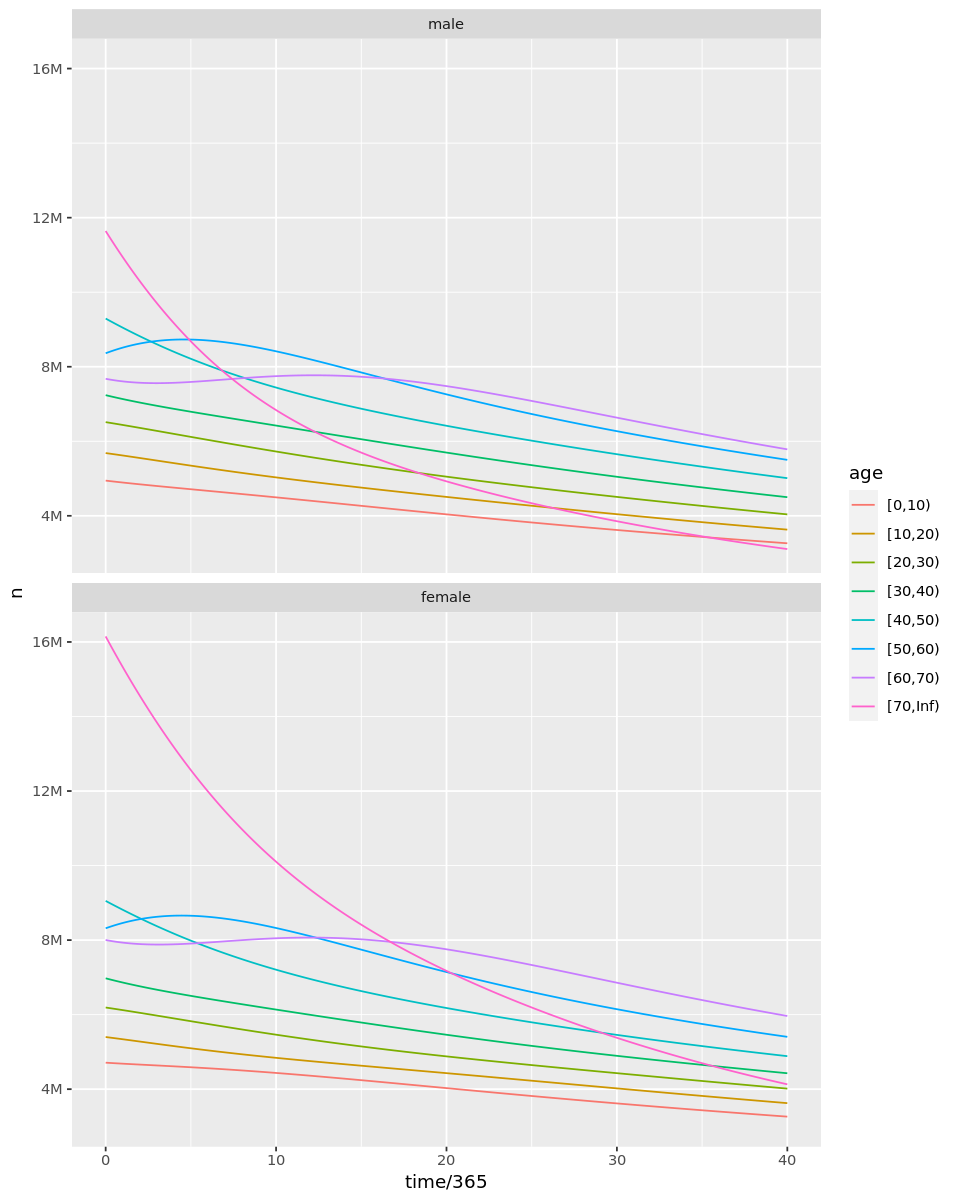

In [326]:
figsize(height=10)
df %>%
    group_by(time, sex, 
             age = cut(age, right = FALSE, breaks = c(0,10,20,30,40,50,60,70,Inf))) %>%
    summarise(n = sum(n)) %>%
    ggplot() +
    facet_wrap(ncol=1, ~sex) +
    geom_line(aes(time/365, n, col=age)) +
    scale_y_continuous(labels = label_number_si())

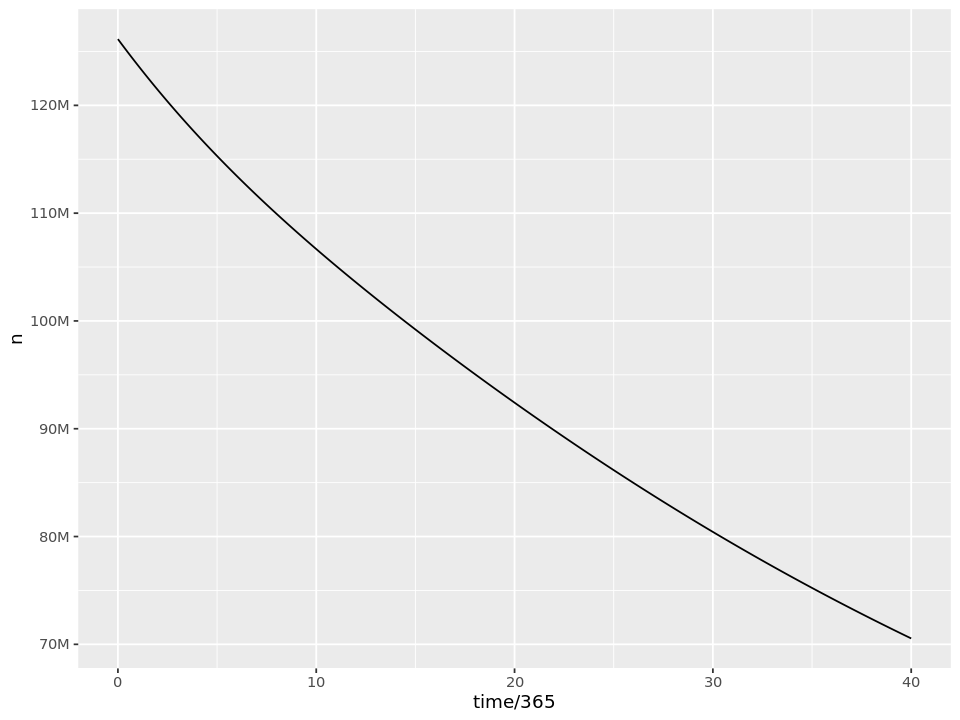

In [315]:
figsize()
df %>%
    group_by(time) %>%
    summarise(n = sum(n)) %>%
    ggplot() +
    geom_line(aes(time/365,n)) +
    scale_y_continuous(labels = label_number_si())

In [ ]:
df %>%
    filter(time %in% (c(0,20,40)*365)) %>%
    group_by(time) %>%
    

In [306]:
df %>% filter(time == 365*10)  %>% pull(n) %>% sum(.)/1e6

[1] 106.6685

In [307]:
df %>%
    filter(time == 365*20)  %>% pull(n) %>% sum(.)/1e6

[1] 92.41847

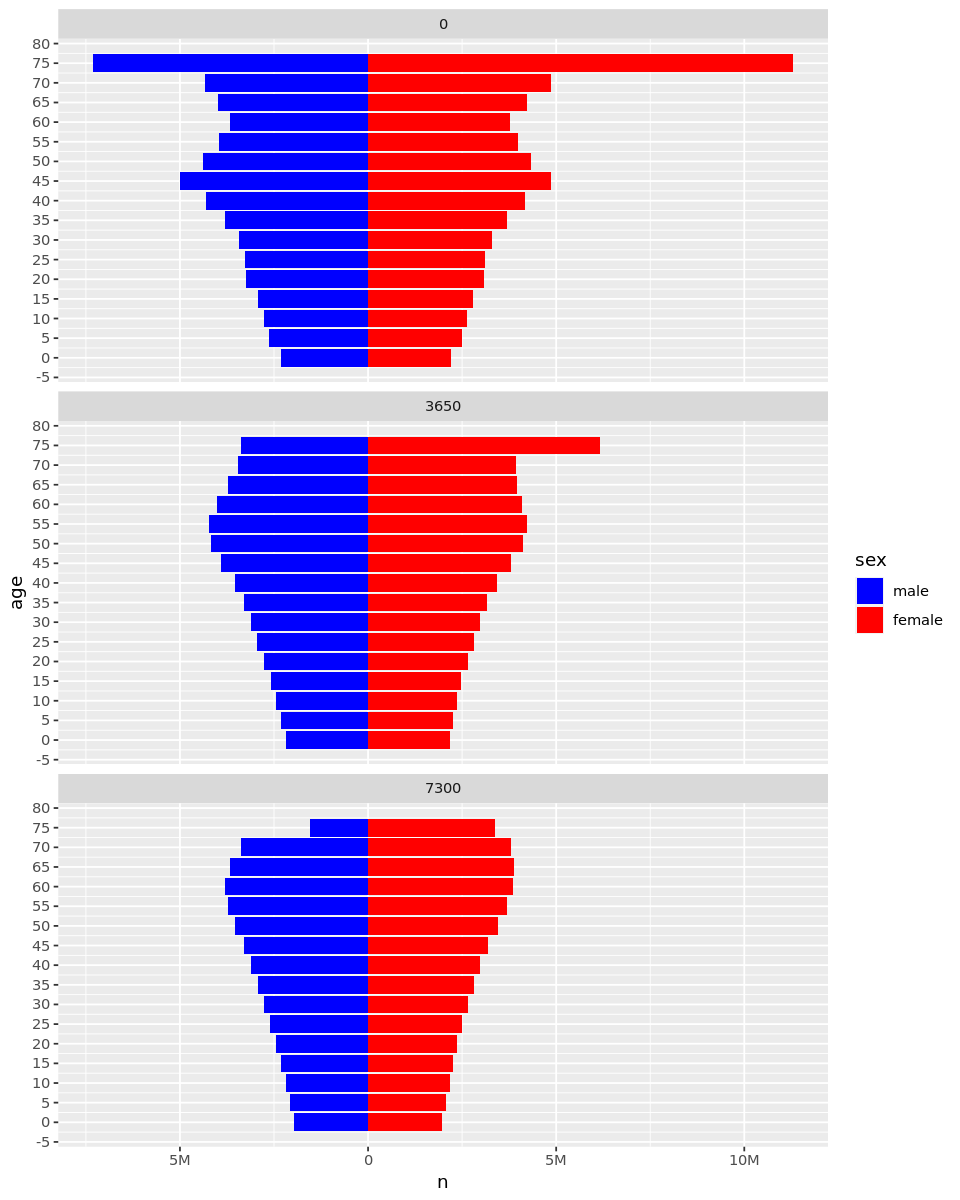

In [291]:
df %>%
    filter(time %in% (c(0, 10, 20)*365)) %>%
    mutate(n = if_else(sex == 'male', -n, n)) %>%
    ggplot() +
    facet_wrap(ncol=1, ~time) +
    geom_bar(aes(age,n,fill=sex), stat = 'identity') +
    scale_fill_manual(values = c('blue', 'red')) +
    coord_flip() +
    scale_y_continuous(labels = label_number_si() %o% abs) +
    scale_x_continuous(breaks = breaks_width(5))

## Simulation

In [123]:
u0 = c()
u0[S] = with(population, c(male, female))
u0[I] = 0 # with(population, c(male, female)*1e-6)
u0[c(R,A,Dn,Dd)] = 0

timeit({
sol = ode(
    u0,
    seq(0,365*20,by=1),
    make.model(spec),
    params
)
invisible()
})

Time difference of 4.90659 secs


NULL

In [77]:
data = data.frame(sol) %>%
    mutate(across(starts_with('D'), ~ . - lag(.), .names = 'delta{.col}')) %>%
    pivot_longer(-time, names_to = 'label') %>%
    separate(label, c('symbol', 'sex', 'age')) %>%
    group_by(
        time,
        symbol,
        sex,
        age.group = cut(as.numeric(age), right = FALSE, breaks = c(0,20,40,60,Inf))
    ) %>%
    summarise(
        value = sum(value)
    ) %>%
    ungroup() %>%
    mutate(
        symbol = fct_relevel(symbol, c('S', 'I', 'R', 'A')),
        age.group = factor(age.group, levels = str_sort(unique(age.group), numeric = TRUE))
    )

`summarise()` has grouped output by 'time', 'symbol', 'sex'. You can override
using the `.groups` argument.


In [249]:
df = data.frame(sol) %>%
    pivot_longer(-time) %>%
    separate(name, c('symbol', 'sex', 'age')) %>%
    group_by(time,sex,age) %>%
    summarise(value = sum(value))

`summarise()` has grouped output by 'time', 'sex'. You can override using the
`.groups` argument.


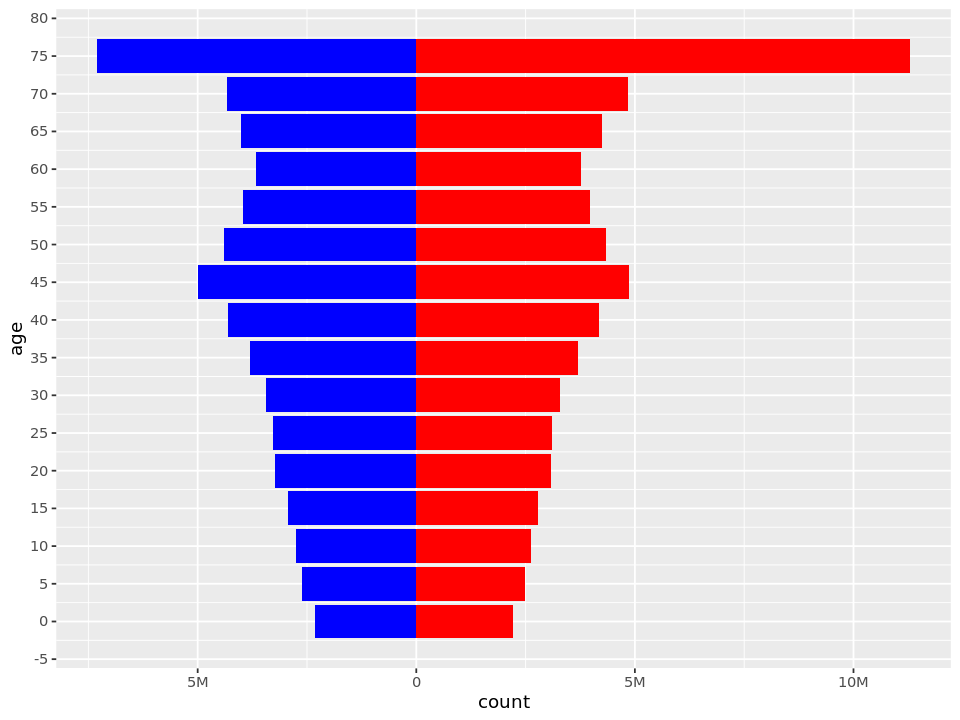

In [250]:
figsize()
df %>%
    mutate(age = as.numeric(age)) %>%
    pivot_wider(names_from = sex) %>%
    filter(time==0) %>%
    ggplot() +
    geom_bar(aes(age, female), fill = 'red', stat = 'identity') +
    geom_bar(aes(age, -male), fill = 'blue', stat = 'identity') +
    scale_x_continuous(breaks = breaks_width(5)) +
    scale_y_continuous(labels = label_number_si() %o% abs) +
    labs(y = 'count') +
    coord_flip()

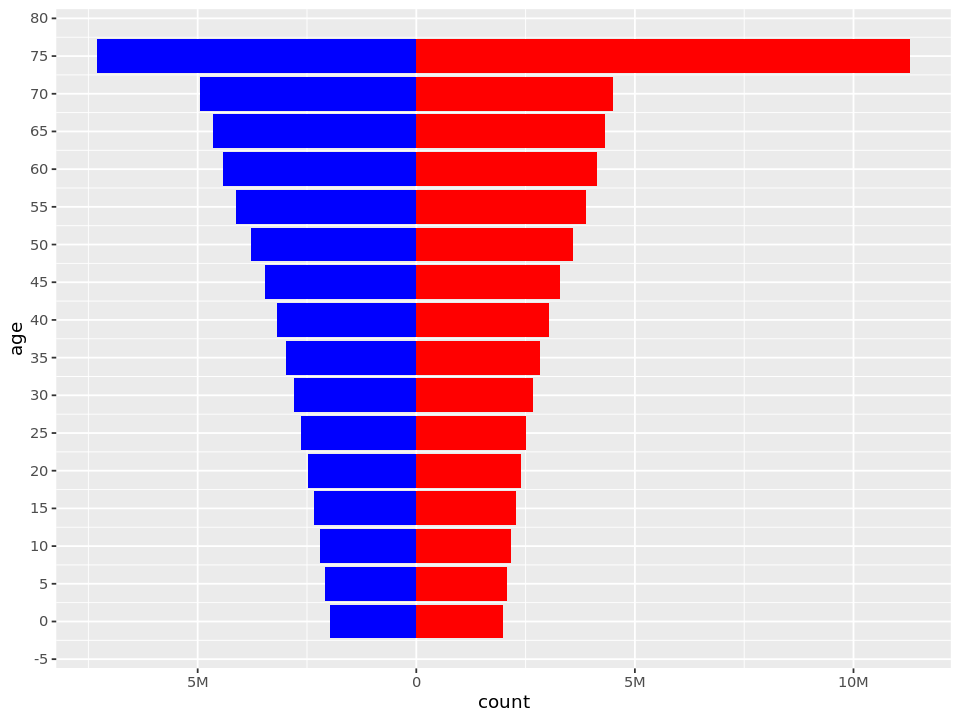

In [251]:
figsize()
df %>%
    mutate(age = as.numeric(age)) %>%
    pivot_wider(names_from = sex) %>%
    filter(time==365*20) %>%
    ggplot() +
    geom_bar(aes(age, female), fill = 'red', stat = 'identity') +
    geom_bar(aes(age, -male), fill = 'blue', stat = 'identity') +
    scale_x_continuous(breaks = breaks_width(5)) +
    scale_y_continuous(labels = label_number_si() %o% abs) +
    labs(y = 'count') +
    coord_flip()

In [73]:
df = data %>%
    filter(!(symbol %in% c('Dd', 'Dn'))) %>%
    group_by(time,symbol,age.group) %>%
    summarise(value=sum(value)) %>%
    pivot_wider(names_from = symbol, values_from = value) %>%
    mutate(`prop. of infection death` = deltaDd/(deltaDd+deltaDn))
head(df)

`summarise()` has grouped output by 'time', 'symbol'. You can override using
the `.groups` argument.


time age.group S        I        R        A            deltaDd      deltaDn 
1 0    [0,20)    20737887 20.73791 0.000000 0.000000e+00           NA       NA
2 0    [20,40)   26916231 26.91626 0.000000 0.000000e+00           NA       NA
3 0    [40,60)   35022874 35.02291 0.000000 0.000000e+00           NA       NA
4 0    [60,Inf)  43468981 43.46902 0.000000 0.000000e+00           NA       NA
5 1    [0,20)    20739812 24.07567 4.437856 8.041098e-07 0.0002041282 11.19208
6 1    [20,40)   26915198 38.09739 6.417810 1.975437e-06 0.0039456048 33.99486
  prop. of infection death
1           NA            
2           NA            
3           NA            
4           NA            
5 1.823831e-05            
6 1.160513e-04

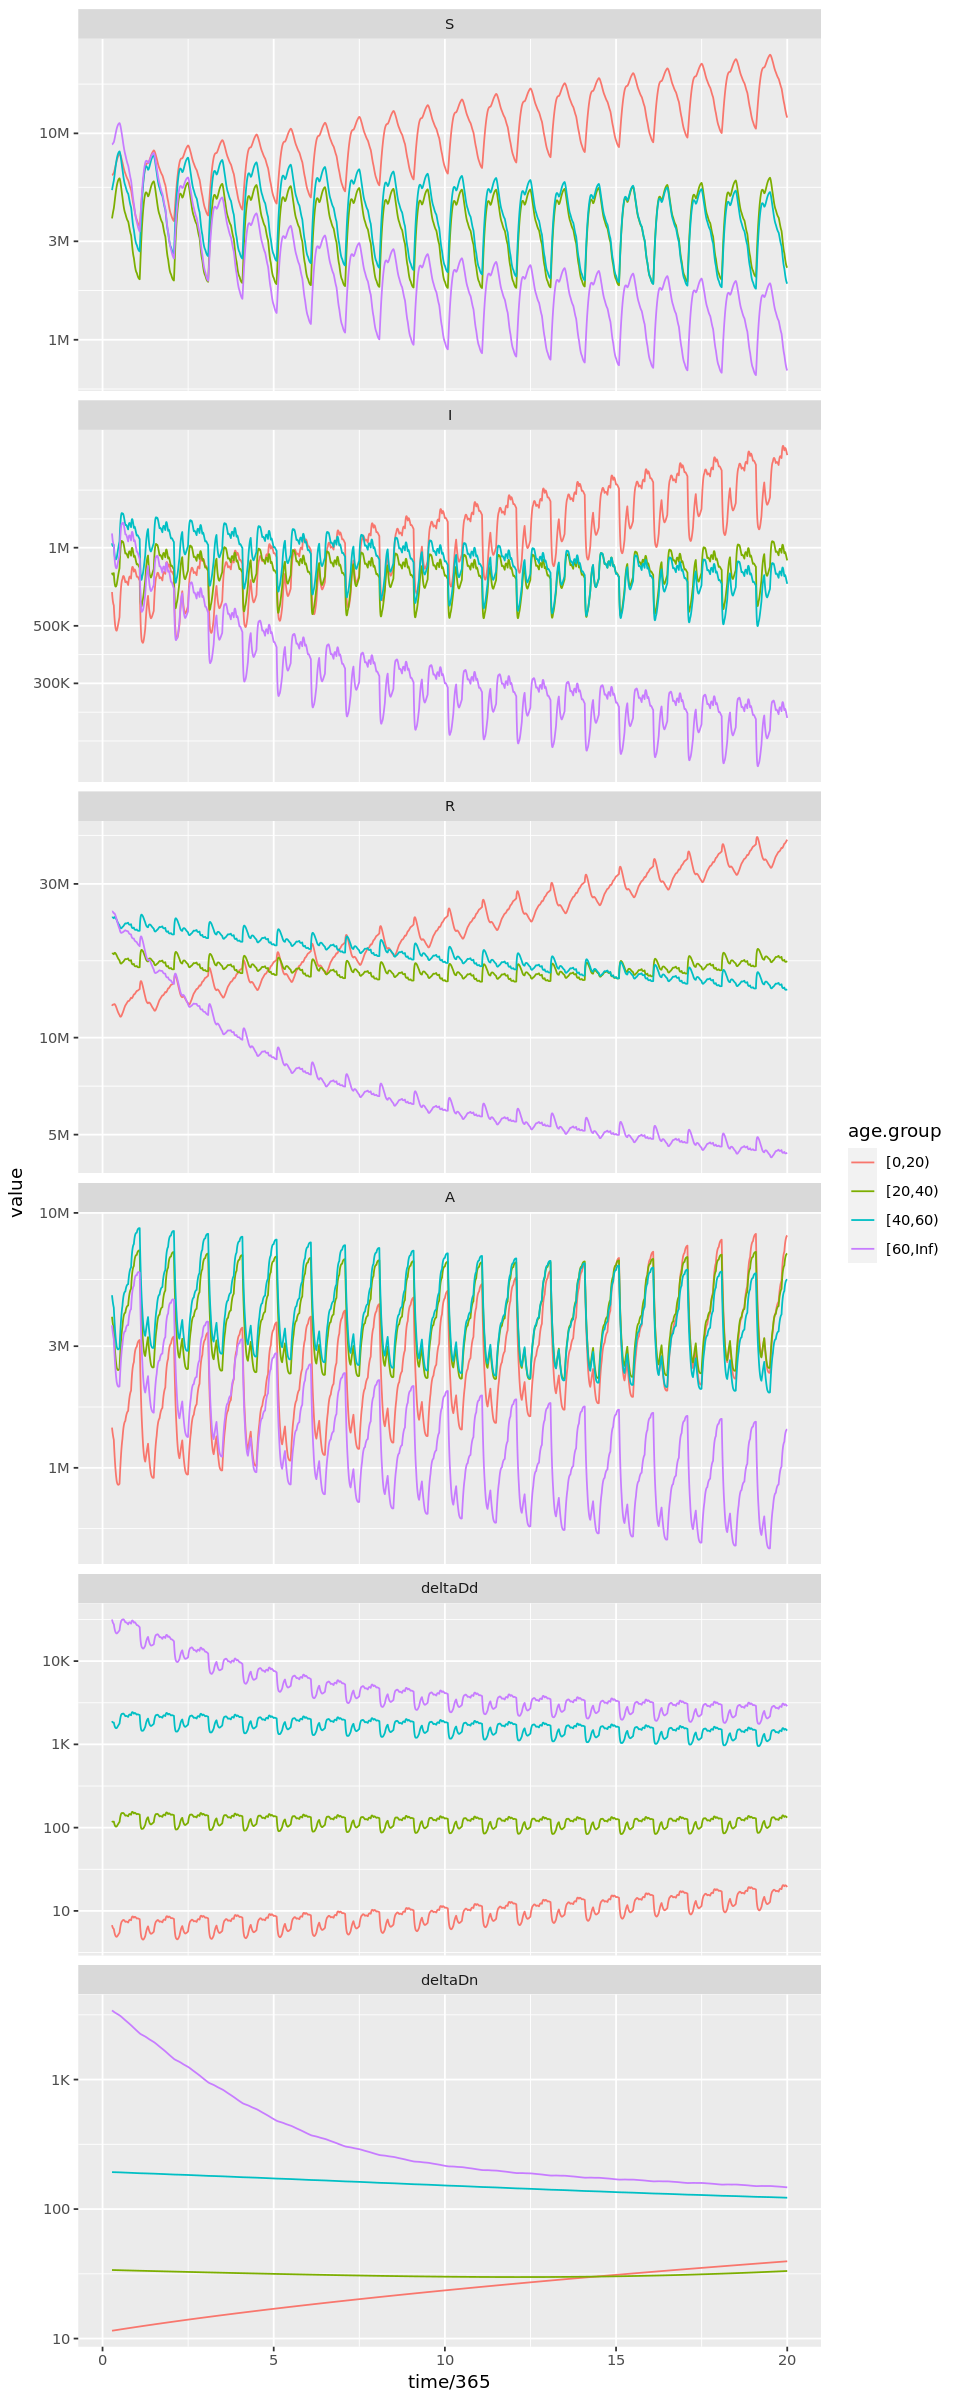

In [74]:
figsize(height=20)
df %>%
    select(time, age.group, S, I, R, A, deltaDd, deltaDn) %>%
    pivot_longer(-c(time,age.group)) %>%
    filter(time > 100) %>%
    mutate(name = fct_relevel(name, c('S', 'I', 'R', 'A'))) %>%
    ggplot() +
    facet_wrap(name ~ ., ncol=1, scales = 'free_y') +
    geom_line(aes(time/365, value, col=age.group)) +
    scale_y_log10(labels = label_number_si())